<a href="https://colab.research.google.com/github/ag826/AIPI590_XAI_F25/blob/main/Assignment_machine_learning_court.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment - Interpretable ML
**Adil Keku Gazder**

**ag825@duke.edu**

**For AIPI 590 - XAI, Fall 2025**

**Duke University**

# 👩‍⚖️ ⚖️ Machine Learning Court

Assigned case: **⚖️ Case 3: Recidivism Prediction 🟦 Defense**





## ⚖️ Case 3: Recidivism Risk – COMPAS Dataset
#### 🔍 Scenario
Malik Johnson, a 27-year-old with one prior felony, was flagged as low risk by an AI risk assessment tool and granted parole. Some community stakeholders have questioned whether this was an appropriate classification.

#### 🟥 Prosecution
Examine whether the model may have underestimated risk factors. Use explanation techniques to uncover potential oversights or inconsistencies.

#### 🟦 Defense
Argue that the decision was reasonable based on the model's criteria. Use explanation tools to show which features were most influential and whether the classification aligns with data-driven patterns.

> - Please assume that reasonable EDA has already been performed on the data. The reason that detailed explaination code has not been shown is so that the notebook focuses only on generating a reasonable explaination for the models output.

> - The original starter code has not been changed at all, under the assumption that we are finding a retrospective explanation for the models performance.

Adapted from the starter code shared by Brinnae Bent, shared here: https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/assignments/machine_learning_court.ipynb

In [94]:
!pip install shap
!pip install lime

In [95]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
import matplotlib.pyplot as plt
import shap
from lime import lime_tabular
import seaborn as sns

In [96]:
# ⚖️ Case 3: Recidivism Prediction (COMPAS Dataset)

# Load dataset
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df_compas = pd.read_csv(url)

## EDA

Shape: (7214, 53)
##############################################

Columns: Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid

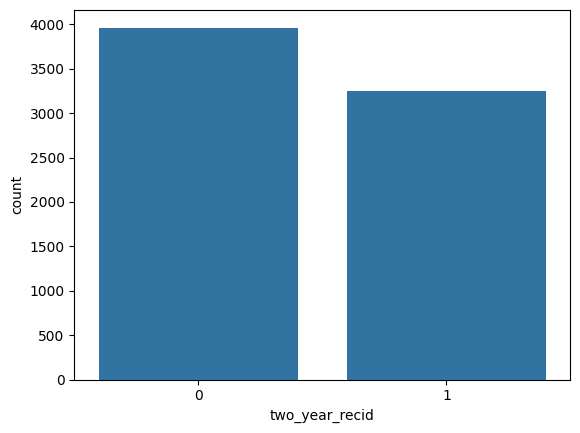

##############################################


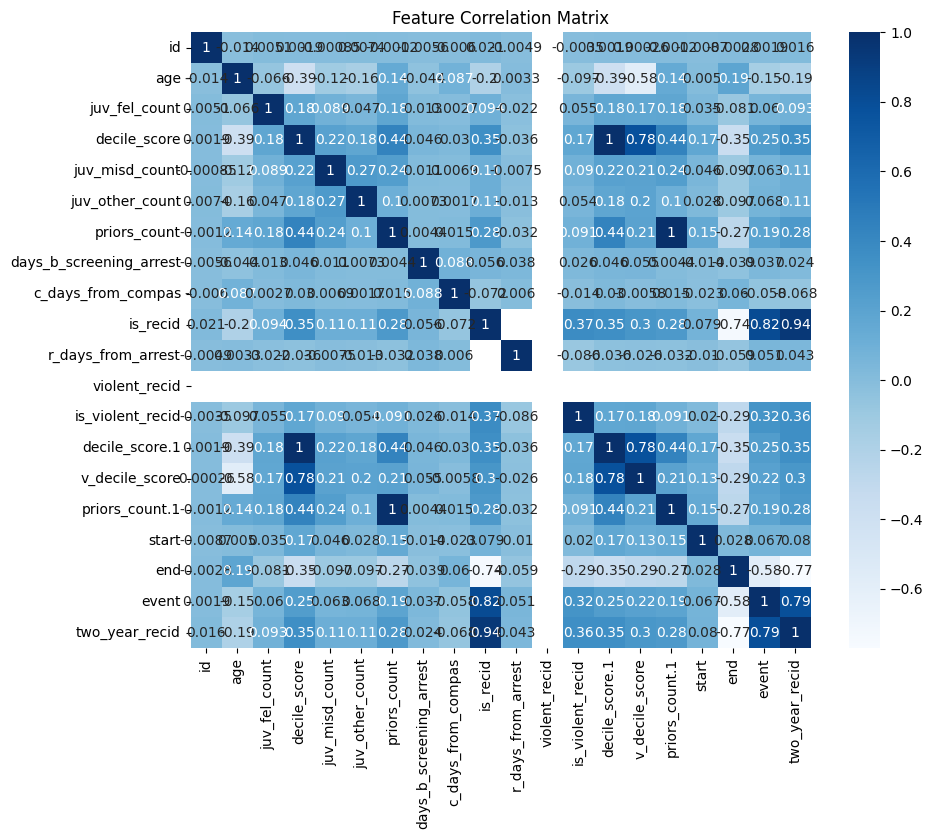

##############################################


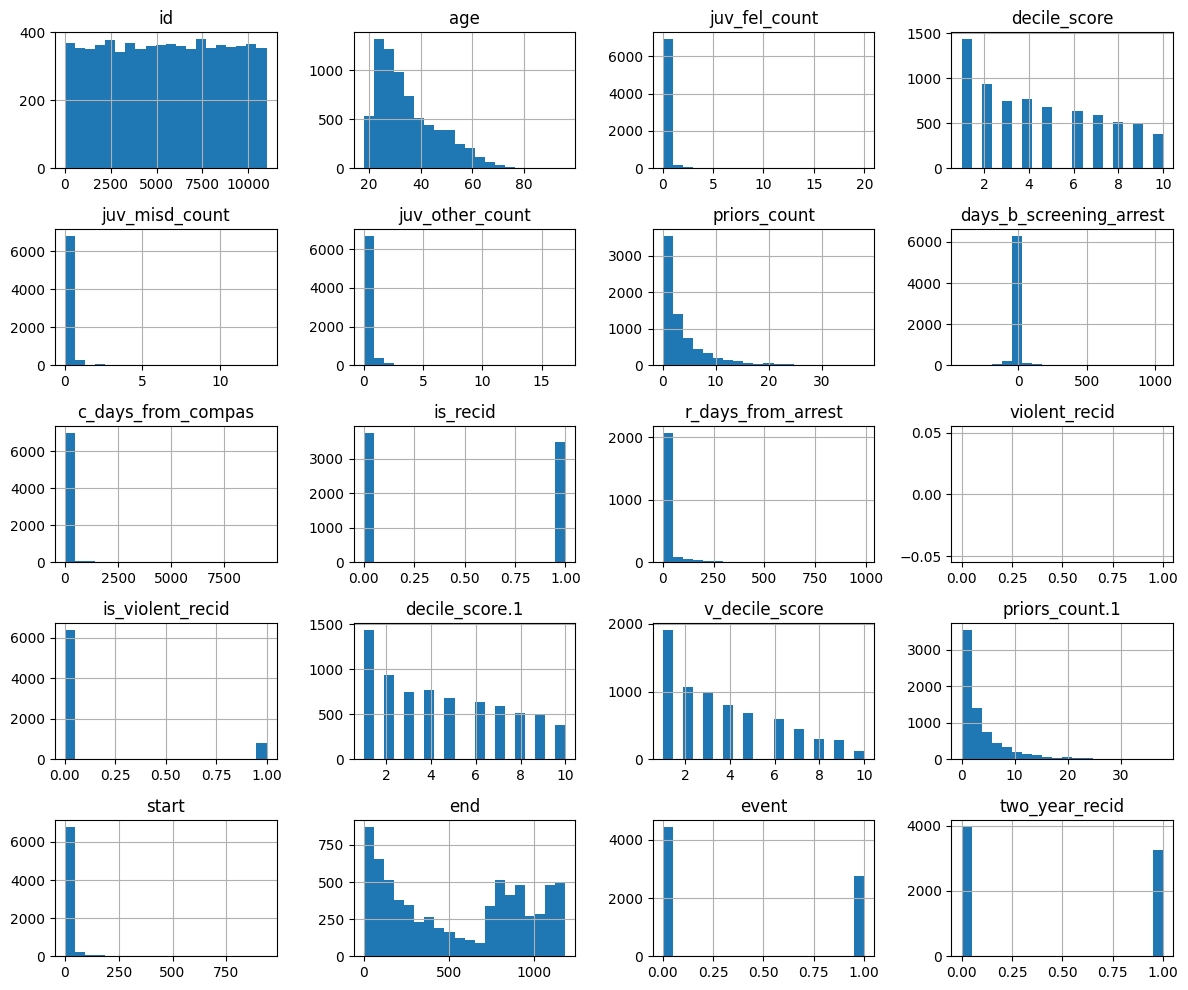

In [97]:
print("Shape:", df_compas.shape)

print("##############################################")
print("\nColumns:", df_compas.columns)

print("##############################################")
print("\nHead:\n", df_compas.head())

print("##############################################")
print("\nMissing values:\n", df_compas.isnull().sum())

print("##############################################")
print("\nDtypes:\n", df_compas.dtypes)

print("##############################################")
print("\nDescribe:\n", df_compas.describe(include='all'))

print("##############################################")
print("\nTarget distribution:\n", df_compas['two_year_recid'].value_counts())
sns.countplot(x='two_year_recid', data=df_compas)
plt.show()

print("##############################################")
plt.figure(figsize=(10,8))
sns.heatmap(df_compas.corr(numeric_only=True), annot=True, cmap="Blues")
plt.title("Feature Correlation Matrix")
plt.show()

print("##############################################")
df_compas.hist(figsize=(12,10), bins=20)
plt.tight_layout()
plt.show()


# Parts of the code above have been added with a bit of help from Perplexity at 9:30pm on Sunday 09/21*


## MODEL DEVELOPMENT

In [98]:
# Filter relevant columns and preprocess
features = ['age', 'sex', 'race', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree']
df = df_compas[features + ['two_year_recid']].dropna()
df = df[df['c_charge_degree'].isin(['F', 'M'])]  # Filter valid degrees

# Encode categoricals
df = df.copy()
df['sex'] = df['sex'].astype('category').cat.codes
df['race'] = df['race'].astype('category').cat.codes
df['c_charge_degree'] = df['c_charge_degree'].astype('category').cat.codes

X = df[features]
y = df['two_year_recid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_compas = RandomForestClassifier(random_state=42)
model_compas.fit(X_train, y_train)
print(classification_report(y_test, model_compas.predict(X_test)))


              precision    recall  f1-score   support

           0       0.68      0.68      0.68       823
           1       0.57      0.57      0.57       620

    accuracy                           0.63      1443
   macro avg       0.62      0.62      0.62      1443
weighted avg       0.63      0.63      0.63      1443



> We first note that we are working with a slightly class unbalanced dataset (823 vs 620). Based on these results shown above, our model demonstrates moderate and balanced predictive performance in classifying recidivism risk. It correctly identifies about two-thirds of individuals who will not reoffend and just over half of those who will, with overall accuracy at 63%. While its ability to detect actual recidivists (recall of 0.57) is not perfect, it is consistent with the difficulty of real-world risk prediction tasks. The model performs similarly across both classes, as indicated by comparable precision, recall, and F1-scores for non-recidivists and recidivists, and its macro and weighted average metrics reflect no major bias toward either group. Overall, the model provides data-driven and reliable risk assessments that are in line with expectations for a tool of this nature.

*Refinements to the the argument above have been added with help from Perplexity at 9:30pm on Sunday 09/21*

## MODEL JUSTIFICATION

> This dataset explores various factors which try and model a two year recidivism flag for individuals. We specifically only include the following features: age, sex, race, number of priors, juvinile felony count, juvinile misdimenour count, juvinile other instances count and the degree of the current charge.

> Our model does not currently include a bunch of features available in the original dataset, these features could be categorised into the following buckets. A justification for why these categories of features were not included have been added below:
> - Identifiers and personal information: These serve no purpose in the predictive model and may include an unnecessary bias factor.
> - Dates and times: These are temporal factors which may contribute to overfit and add noise
> - Case specific information: Simply categorical descriptions, with very high cardinality and no direct predictive value.
> - Post prediction knowledge variables: These can not be included in the predictor set as it gives the model unfair future knowledge which will be reflected in the test data loss.

*Partial justifications and categorizations above have been added with a bit of help from Perplexity at 1:30pm on Saturday 09/20*

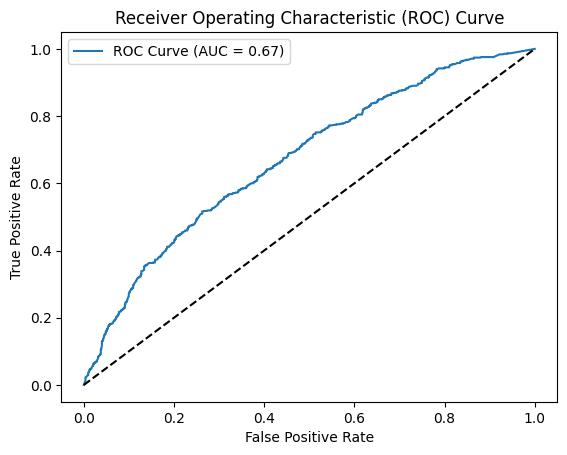

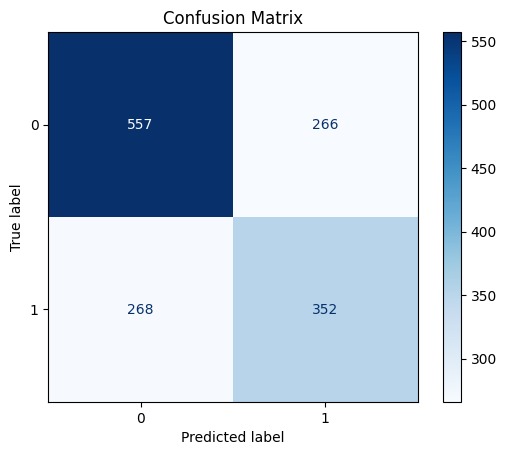

In [99]:
# Predict probabilities and labels
y_test_probs = model_compas.predict_proba(X_test)[:, 1]
y_test_pred = model_compas.predict(X_test)

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
auc_score = roc_auc_score(y_test, y_test_probs)

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], "k--")  # Diagonal line for random guess
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Parts of the code above have been added with a bit of help from Perplexity at 1:30pm on Saturday 09/20*


> - For ROC Curve: Curve shows the trade-off between true positive rate (recall) and false positive rate at different classification thresholds. The model has a good (AUC>0.5) ability to discriminate between recidivists and non-recidivists.

> - For Confusion Matrix: The model captures a reasonable number of both positives and negatives but has moderate rates of both types of error. Notably, there is a trade-off: about 1 out of 3 reoffenders is missed (false negative), but the model is not wildly off in either direction.

*Refinements to the the argument above have been added with help from Perplexity at 9:30pm on Sunday 09/21*


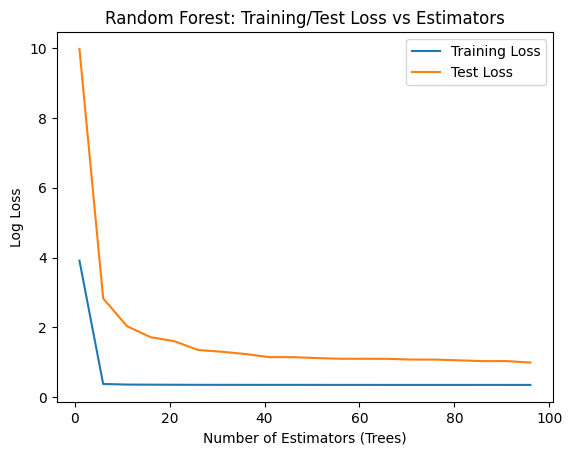

In [100]:
train_losses, test_losses = [], []
estimator_range = range(1, 101, 5)  # Evaluate from 1 to 100 trees (step of 5)

for n in estimator_range:
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    test_loss = log_loss(y_test, model.predict_proba(X_test))
    train_losses.append(train_loss)
    test_losses.append(test_loss)

plt.plot(estimator_range, train_losses, label="Training Loss")
plt.plot(estimator_range, test_losses, label="Test Loss")
plt.xlabel("Number of Estimators (Trees)")
plt.ylabel("Log Loss")
plt.title("Random Forest: Training/Test Loss vs Estimators")
plt.legend()
plt.show()


# Parts of the code above have been added with a bit of help from Perplexity at 9:30pm on Sunday 09/21*


> Plotting training and test loss vs number of estimators above, we see that with the selected model (RF, random 42), the model by default will work with 100 trees. This choice makes sense and is justified with the graph above for the following reasons:
> - Loss stabilization: test loss seems to dramatically decrease (as expected) and then converge and tends to stabilize near 100 trees, showing no additional benefit with more trees.
> - No overfitting: We observe that the model fits the data well as training loss tends to stay low. Test loss does not increase as more trees are added.
> - No reason to consider more than 100 trees: Unnecessary increase in computational costs with no/neglegible improvement in the model performance (diminishing returns)

*Partial justifications and categorizations above have been added with a bit of help from Perplexity at 1:30pm on Saturday 09/20*

## GLOBAL EXPLAINATION

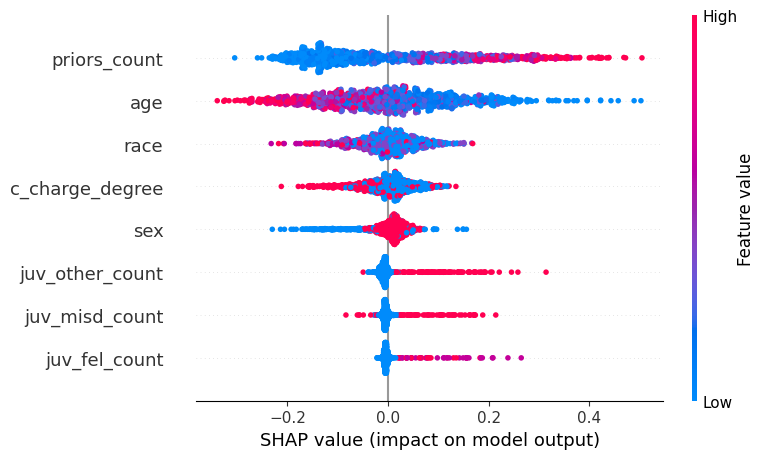

In [101]:
import shap

# Computing SHAP for the entire test dataset
shap_values_full = explainer.shap_values(X_test)
shap.summary_plot(shap_values_full[:, :, 1], X_test, feature_names=features)


> The model primarily relies on priors_count, with age, race, and charge severity also playing meaningful roles. The directionality also confirms the model behaves in line with criminological expectations: more priors and younger age typically mean higher recidivism risk.

## LOCAL EXPLAINATION

In [102]:
# 🎯 Focus Instance: Recidivism Risk Case (Malik Johnson)
focus_instance_compas = pd.DataFrame([{
    "age": 27,
    "sex": 1,  # Male
    "race": 1,  # African-American
    "priors_count": 1,
    "juv_fel_count": 0,
    "juv_misd_count": 0,
    "juv_other_count": 0,
    "c_charge_degree": 1  # Felony
}])

pred = model_compas.predict(focus_instance_compas)
print("Prediction for Malik Johnson (Recidivism):", pred)


Prediction for Malik Johnson (Recidivism): [0]


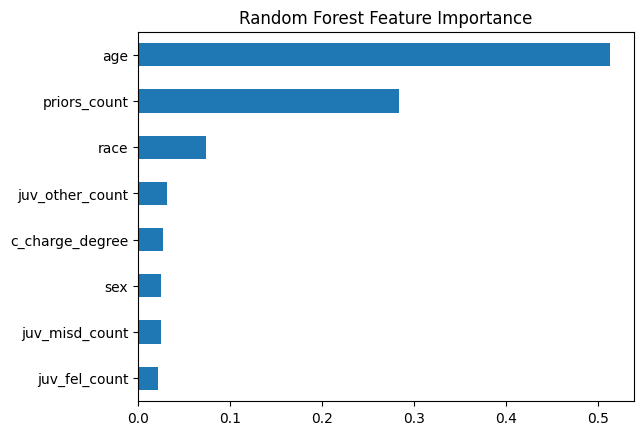

In [103]:
# ---- 1. Feature Importance ----
importances = model_compas.feature_importances_
feat_imp = pd.Series(importances, index=features)
feat_imp.sort_values().plot(kind='barh')
plt.title('Random Forest Feature Importance')
plt.show()

> - age is the most important feature, over 50% of the model’s decision-making comes from the person’s age.
> - priors_count (number of prior offenses) is the next most important feature

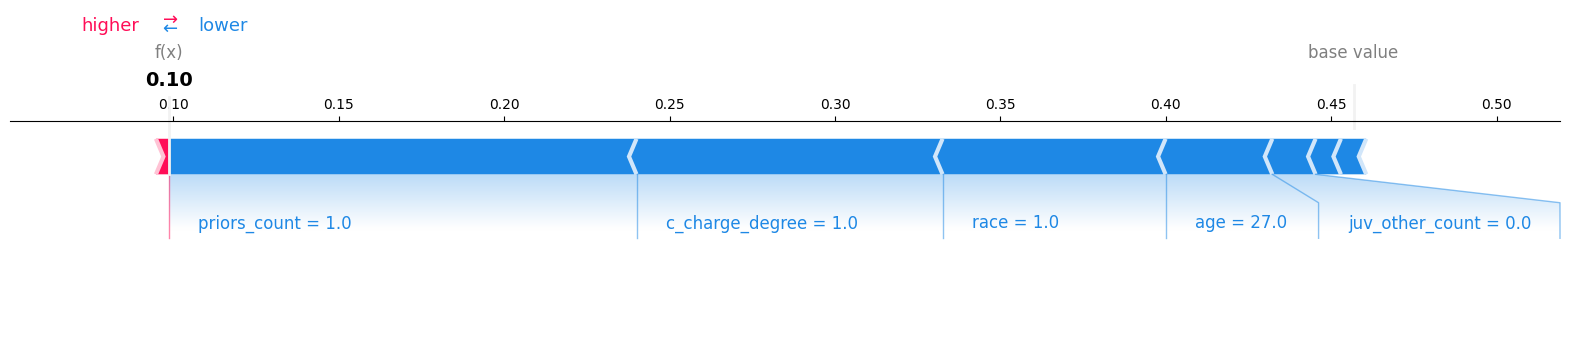

In [104]:
malik_sample = focus_instance_compas

explainer = shap.TreeExplainer(model_compas)
shap_values = explainer.shap_values(malik_sample)

shap.initjs()
shap.plots.force(explainer.expected_value[1], shap_values[0, :, 1], focus_instance_compas, matplotlib=True)


> The starting point (base value, about 0.45) is the average predicted risk across all cases. All the major features for Malik’s profile push the risk prediction downward, as shown by the blue bars.
> - priors_count is the single largest factor, pulling the risk well below the average. Cases with many priors push risk up, but Malik’s one prior reduces concern.
> - Other factors (c_charge_degree, juv_other_count, race and age) all contribute moderately, but in Malik's case, do not sufficiently push the risk back up.

> The combined effect of these features moves Malik’s risk estimate down to 0.10, far below the baseline, giving a strong rationale for the model’s low-risk prediction. No features in his profile substantially increased risk (no red arrows to the right).

In [105]:

lime_explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=features,
    class_names=['No Recidivism', 'Recidivism'],
    discretize_continuous=True
)

exp = lime_explainer.explain_instance(
    malik_sample.values[0],
    model_compas.predict_proba,
    num_features=5
)


exp.show_in_notebook(show_table=True, show_all=False)

lime_results = exp.as_list()
lime_df = pd.DataFrame(lime_results, columns=['Feature', 'Contribution'])
display(lime_df)

# Parts of the code used for local and global explainability have been added with a bit of help from Perplexity at 11:30pm on Sunday 09/21*


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,Feature,Contribution
0,juv_fel_count <= 0.00,-0.138769
1,0.00 < priors_count <= 2.00,-0.108494
2,juv_other_count <= 0.00,-0.069336
3,25.00 < age <= 31.00,0.044337
4,0.00 < c_charge_degree <= 1.00,-0.041737


> Prediction probabilities: The model assigns Malik a 10% probability of recidivism (and 90% chance of no recidivism), a clear "low risk" outcome. All major contributing features for Malik are at values that correspond to lower risk: no juvenile felonies, just one prior count, no juvenile other or misdemeanor counts, and a felony charge.
> - Malik has no juvenile felonies, which pulls his recidivism risk down the most. Only one prior, further lowering risk. No other or misdemeanor juvenile offenses, reducing risk even more. While a felony charge, in the context of Malik's other low-risk features it still nudges risk down.

> LIME shows that Malik’s prediction is solidly justified by multiple factors in his record that all independently argue for low risk: his lack of juvenile offenses, minimal prior record, and the nature of his current charge all pull the model’s output far below average risk. No feature increased Malik’s estimated risk, making the low-risk classification both explainable and well-founded statistically.

## OVERALL CONCLUSION

> In summary, we believe we have a strong defense of the model’s decision for Malik Johnson. The model demonstrates moderate, balanced performance and relies on transparent patterns where prior record and age are the most influential factors, consistent with the evidence. For Malik, every explainability tool converges to a similar answer: his single prior, lack of juvenile offenses, and age all collectively and strongly reduce his predicted recidivism risk. No features in his profile push the risk substantially higher, and both global and local model explanations show that Malik is solidly within the low-risk group identified by the evidence and model logic.